In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import product
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


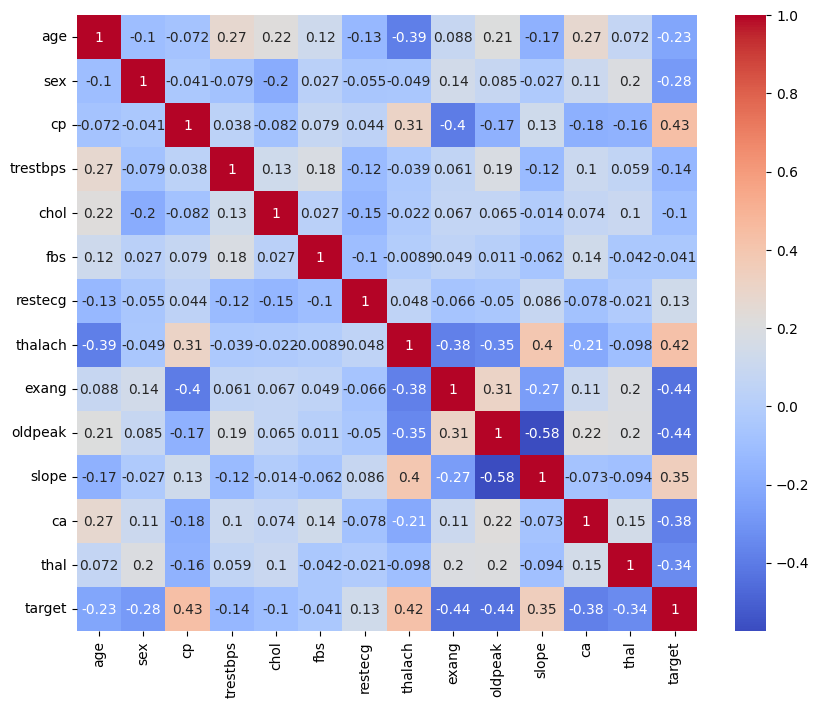

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.show()


In [6]:
data = df.drop(['trestbps','chol','fbs','restecg'],axis=1)

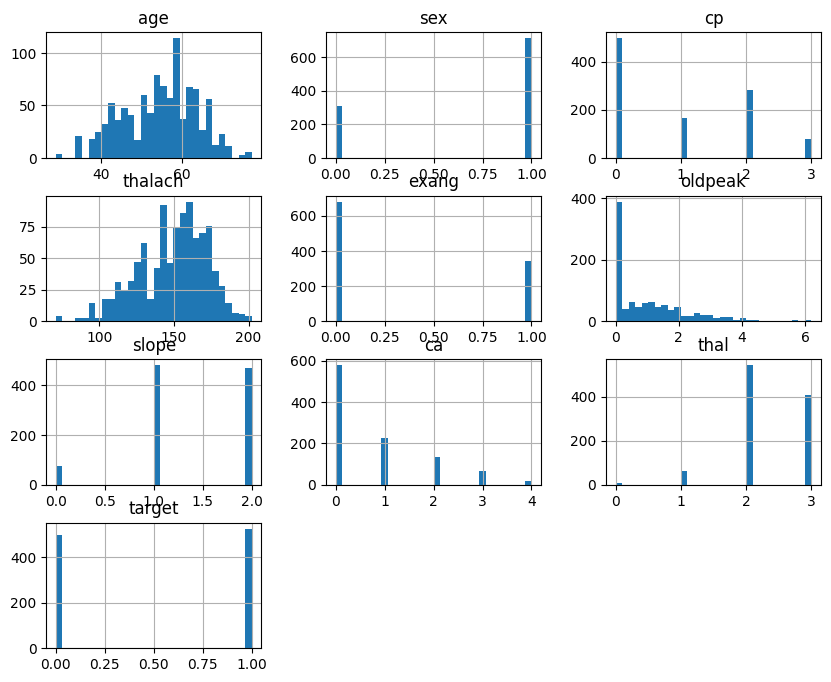

In [7]:
data.hist(bins=30,figsize=(10,8))
plt.show()

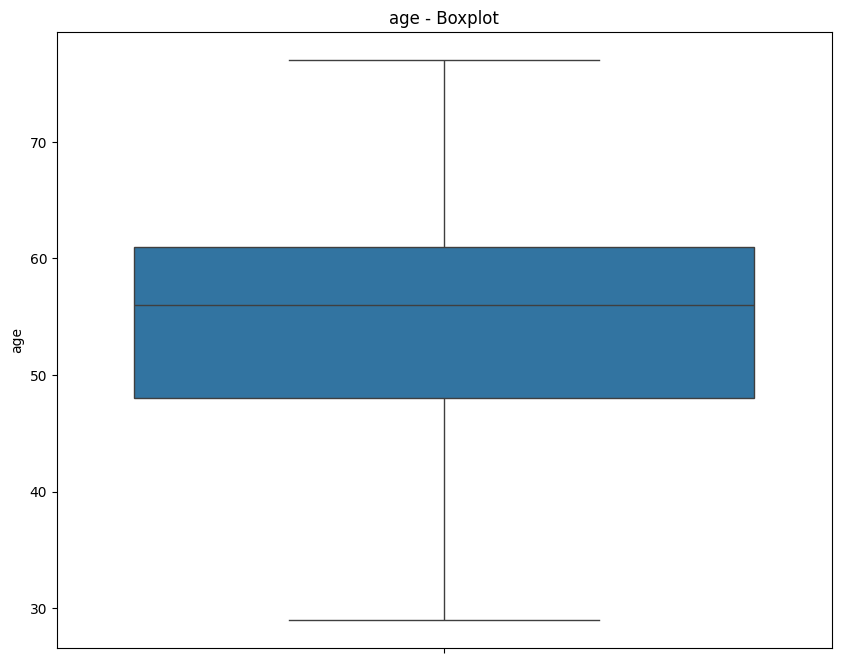

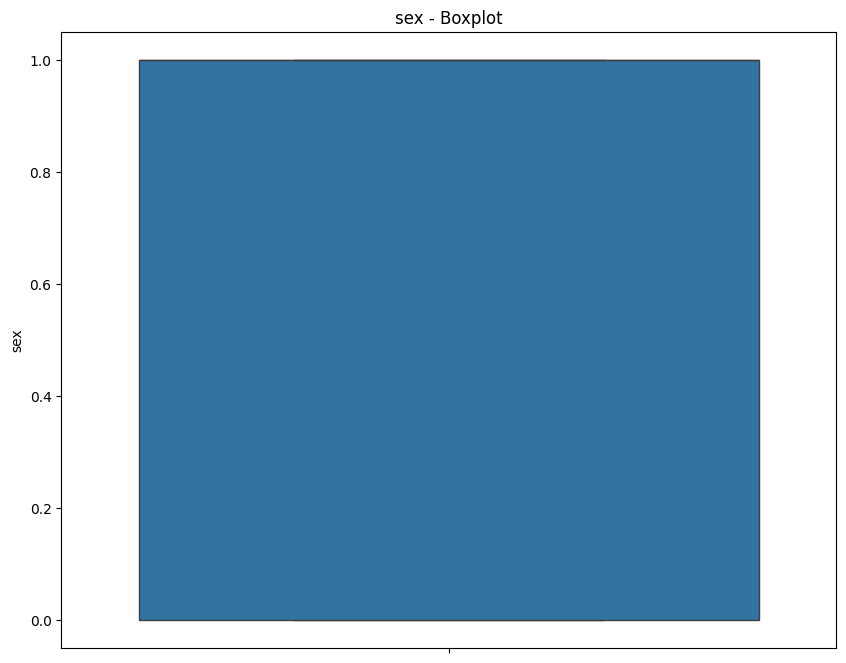

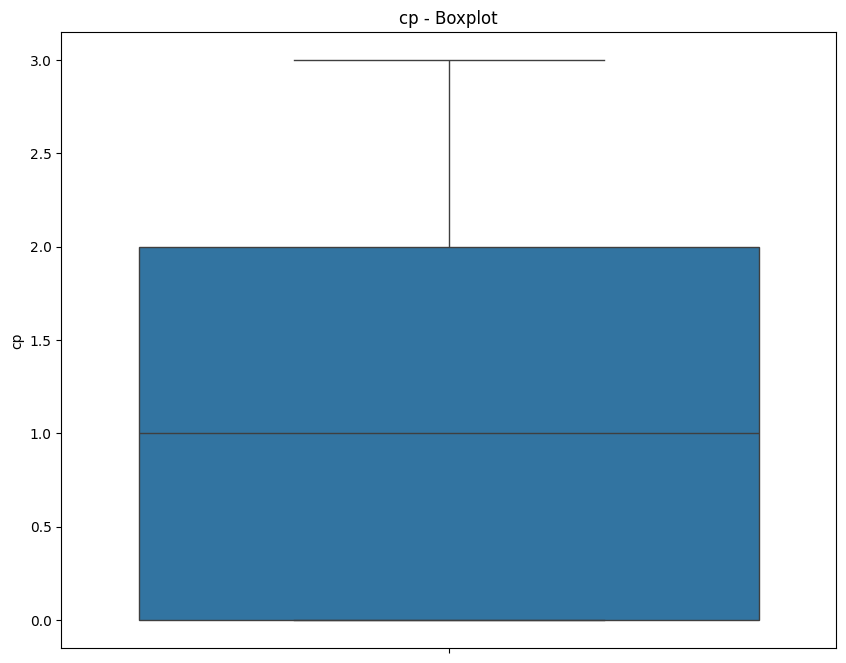

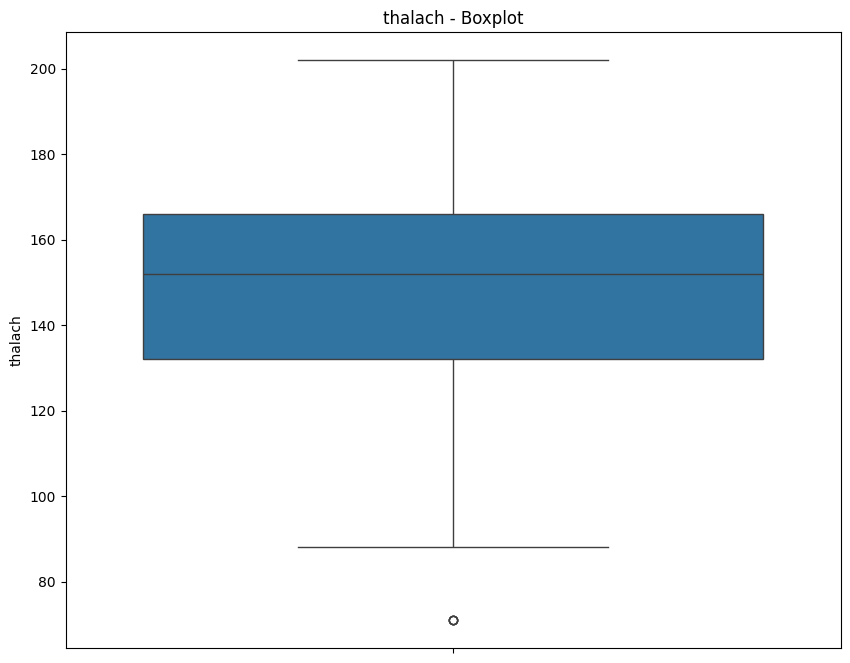

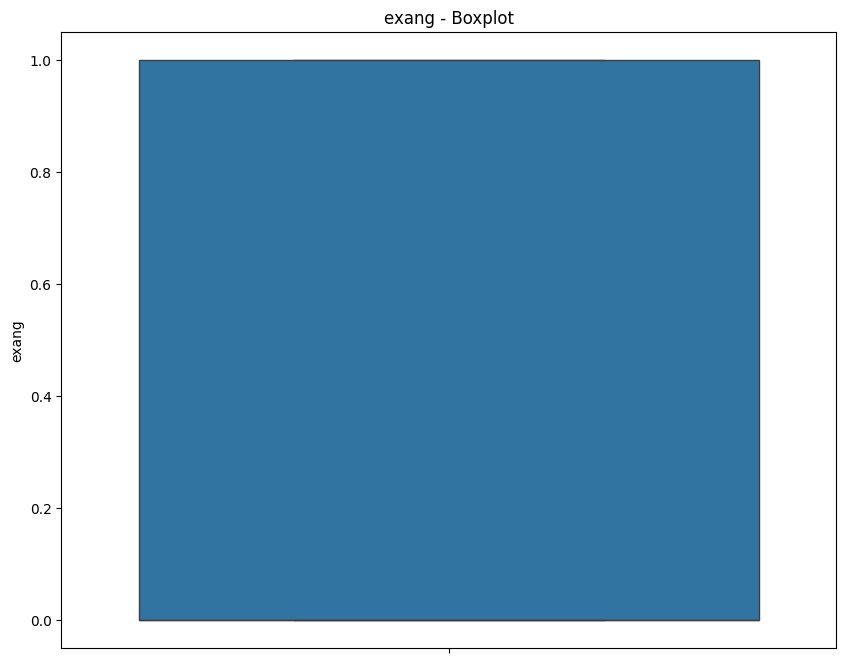

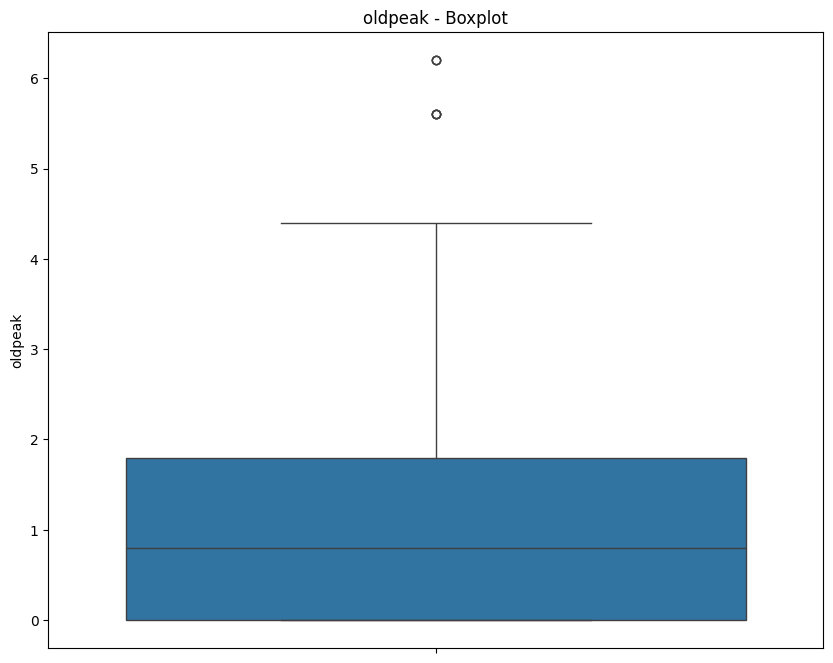

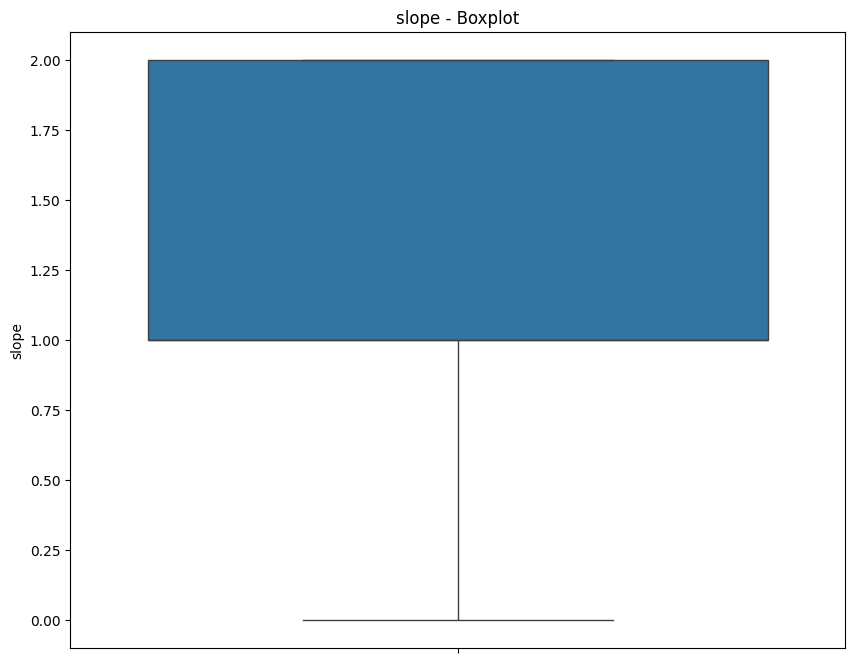

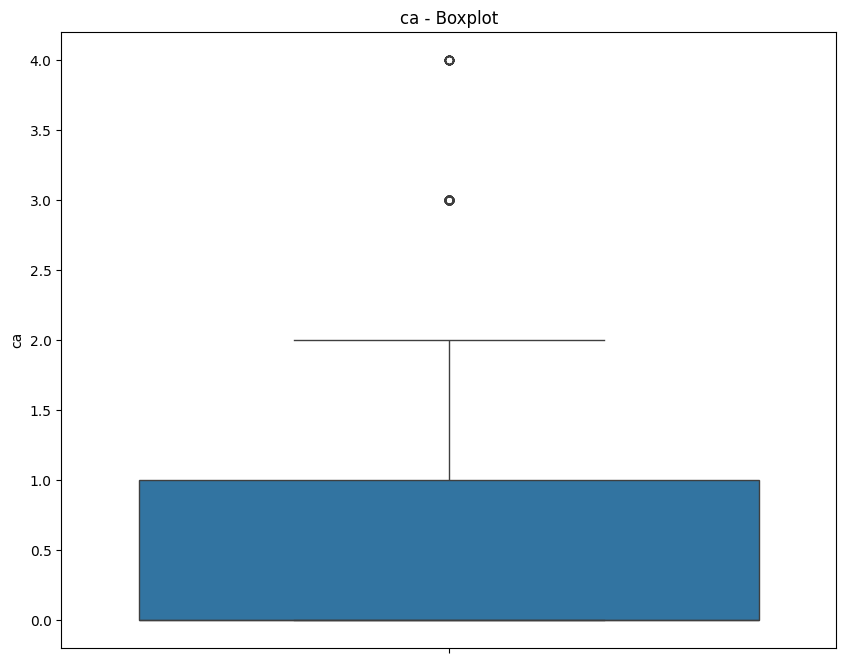

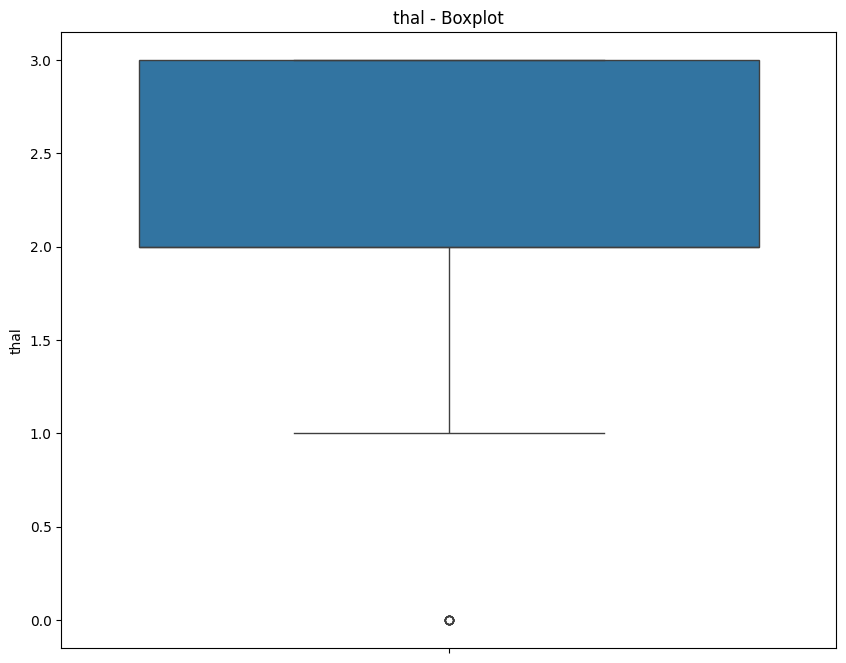

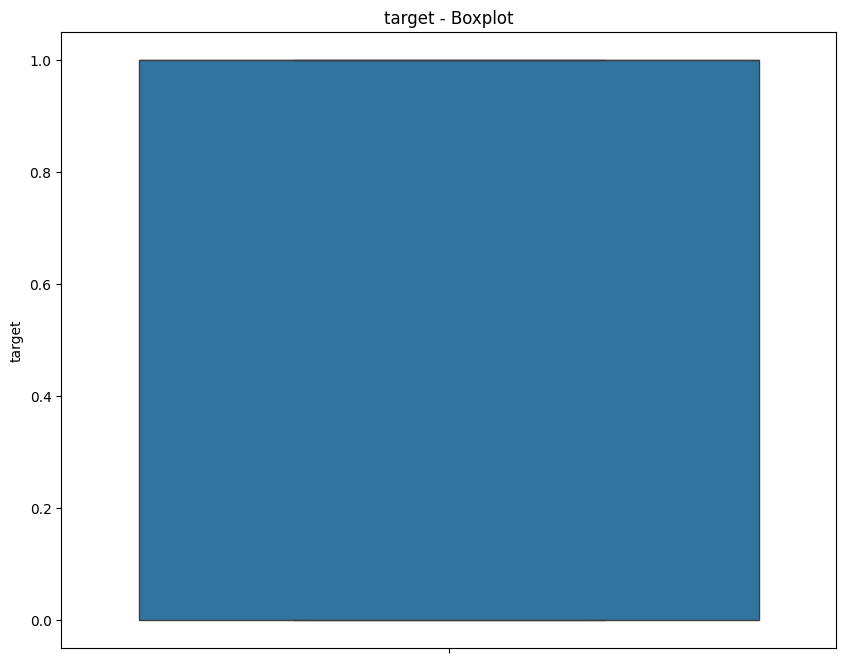

In [8]:
for c in data.columns:
    plt.figure(figsize=(10,8))
    sns.boxplot(y=data[c])
    plt.title(f"{c} - Boxplot")  
    plt.show()  

In [156]:
X = data.drop("target",axis=1)
y = data["target"]

### KNN


In [132]:
class KNN:
    def __init__(self,n_neighbors=5,distance = 'euclidean',weights='uniform'):
        self.n_neighbors = n_neighbors
        self.distance = distance
        self.weights = weights
        self.X_train = None
        self.y_train = None

    def fit(self,X,y):
        self.X_train = X.values if isinstance(X,pd.DataFrame) else X
        self.y_train = y.values if isinstance(y,pd.Series) else y
        return self
    
    def _compute_distance(self,x,p=3):
        if self.distance == 'euclidean':
            # distances — это массив, хранящий расстояния между новым образцом и всеми образцами
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))  
        elif self.distance == 'manhattan':
            distances = np.sum(np.abs(self.X_train - x),axis=1)
        elif self.distance == 'minkowski':
            self.p = p
            distances = np.sum(np.abs(self.X_train - x)**self.p,axis=1)**(1/self.p)
        return distances
    
    def predict(self,X):
        X_test = X.values if isinstance(X,pd.DataFrame) else X
        predictions = []

        for x in X_test:
            distances = self._compute_distance(x)
           # Сортировка обучающих образцов по возрастанию расстояний и получение индексов первых k ближайших соседей
            neighbor_indices = np.argsort(distances)[:self.n_neighbors]
           # Использование индексов массива для применения neighbor_indices к обучающим меткам self.y_train и получения соответствующих категориальных меток
            neighbor_labels = self.y_train[neighbor_indices]

            if self.weights == 'uniform':
                most_common = Counter(neighbor_labels).most_common(1)[0][0]
                predictions.append(most_common)

            elif self.weights == 'distance':
                # Взвешенное голосование, веса — обратные расстояния
                neighbor_distances = distances[neighbor_indices]
                # Предотвращение нулевого расстояния
                neighbor_distances = np.where(neighbor_distances == 0,1e-9,neighbor_distances)
                weights = 1 / neighbor_distances
                label_weight = {}
                for label, weight in zip(neighbor_labels,weights):
                    label_weight[label] = label_weight.get(label,0) + weight
                predicted_label = max(label_weight,key=label_weight.get)
                predictions.append(predicted_label)
            else:
                raise ValueError("Unsupported weight type")
            
        return predictions       

In [196]:
def cross_validation(X, y, model, n_splits=5):  
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)  
    accuracies = []  
    
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):  
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]  
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]  
         
        model.fit(X_train, y_train)  
        
        y_pred = model.predict(X_test)  
        
        accuracy = accuracy_score(y_test, y_pred)  
        accuracies.append(accuracy)  
        
        print(f"Fold {fold}: Accuracy = {accuracy:.4f}")  
    
    mean_accuracy = np.mean(accuracies)  
    print(f"Average Accuracy over {n_splits} folds: {mean_accuracy:.4f}")  
    return mean_accuracy,y_test,y_pred  


In [160]:
knn = KNN(n_neighbors=5,distance = 'manhattan',weights='uniform')
cross_validation(X,y,knn)

Fold 1: Accuracy = 0.8049
Fold 2: Accuracy = 0.8146
Fold 3: Accuracy = 0.8000
Fold 4: Accuracy = 0.8195
Fold 5: Accuracy = 0.7610
Average Accuracy over 5 folds: 0.8000


np.float64(0.8)

Используя подбор гиперпараметров,Чтобы наити найлучиший параметров

In [161]:
def grid_search_knn(X,y,param_grid,n_splits=5):
    keys = param_grid.keys()
    values = param_grid.values()
    param_combinations = list(product(*values))

    best_score = -np.inf
    best_params = None
    results = []

    for combination in param_combinations:
        params = dict(zip(keys,combination))
        #print(f"Evaluating combination {params}")
        model = KNN(**params)
        mean_accuracy = cross_validation(X,y,model,n_splits)
        results.append({'params': params, 'mean_accuracy': mean_accuracy})

        if mean_accuracy > best_score:
            best_score = mean_accuracy
            best_params = params

    print(f"Best Parameters: {best_params} with Accuracy: {best_score:.4f}")  
    return best_params, best_score, results  

In [162]:
param_grid = {  
        'n_neighbors': [3, 5, 7, 9],  
        'distance': ['euclidean', 'manhattan','minkowski'],  
        'weights': ['uniform', 'distance']  
    }  
grid_search_knn(X,y,param_grid)

Fold 1: Accuracy = 0.8976
Fold 2: Accuracy = 0.9317
Fold 3: Accuracy = 0.9707
Fold 4: Accuracy = 0.9171
Fold 5: Accuracy = 0.8976
Average Accuracy over 5 folds: 0.9229
Fold 1: Accuracy = 0.9707
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000
Average Accuracy over 5 folds: 0.9941
Fold 1: Accuracy = 0.9268
Fold 2: Accuracy = 0.9317
Fold 3: Accuracy = 0.9610
Fold 4: Accuracy = 0.9366
Fold 5: Accuracy = 0.9073
Average Accuracy over 5 folds: 0.9327
Fold 1: Accuracy = 1.0000
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000
Average Accuracy over 5 folds: 1.0000
Fold 1: Accuracy = 0.8878
Fold 2: Accuracy = 0.9220
Fold 3: Accuracy = 0.9610
Fold 4: Accuracy = 0.9073
Fold 5: Accuracy = 0.8976
Average Accuracy over 5 folds: 0.9151
Fold 1: Accuracy = 0.9707
Fold 2: Accuracy = 1.0000
Fold 3: Accuracy = 1.0000
Fold 4: Accuracy = 1.0000
Fold 5: Accuracy = 1.0000
Average Accuracy over 5 folds:

({'n_neighbors': 3, 'distance': 'manhattan', 'weights': 'distance'},
 np.float64(1.0),
 [{'params': {'n_neighbors': 3, 'distance': 'euclidean', 'weights': 'uniform'},
   'mean_accuracy': np.float64(0.9229268292682926)},
  {'params': {'n_neighbors': 3,
    'distance': 'euclidean',
    'weights': 'distance'},
   'mean_accuracy': np.float64(0.9941463414634146)},
  {'params': {'n_neighbors': 3, 'distance': 'manhattan', 'weights': 'uniform'},
   'mean_accuracy': np.float64(0.9326829268292682)},
  {'params': {'n_neighbors': 3,
    'distance': 'manhattan',
    'weights': 'distance'},
   'mean_accuracy': np.float64(1.0)},
  {'params': {'n_neighbors': 3, 'distance': 'minkowski', 'weights': 'uniform'},
   'mean_accuracy': np.float64(0.9151219512195121)},
  {'params': {'n_neighbors': 3,
    'distance': 'minkowski',
    'weights': 'distance'},
   'mean_accuracy': np.float64(0.9941463414634146)},
  {'params': {'n_neighbors': 5, 'distance': 'euclidean', 'weights': 'uniform'},
   'mean_accuracy': np.

In [141]:
def evaluate_model(y_true, y_pred):  
    accuracy = accuracy_score(y_true, y_pred)  
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)  
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)  
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)  
    cm = confusion_matrix(y_true, y_pred)  
    
    print(f"Accuracy: {accuracy:.4f}")  
    print(f"Precision: {precision:.4f}")  
    print(f"Recall: {recall:.4f}")  
    print(f"F1 Score: {f1:.4f}")  
    print("Confusion Matrix:")  
    print(cm)  

Используем найденные оптимальные параметры для повторного обучения модели, вычислим её точность, прецизионность, полноту и F1-метрику, а также построим матрицу несоответствий.

In [143]:
knn = KNN(n_neighbors=3,distance = 'manhattan',weights='distance')
X = data.drop('target',axis=1).values
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
evaluate_model(y_test,y_pred)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[102   0]
 [  0 103]]


Повторим предыдущий пункт для библиотечных реализаций из sklearn всех пройденных методов классификации (logistic regression, svm, knn, naive bayes, decision tree).

In [163]:
from sklearn.linear_model import LogisticRegression  
from sklearn.svm import SVC  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB  
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV  

In [205]:
X = data.drop('target',axis=1).values
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Определяем модель и соответствующую сетку гиперпараметров для каждого классификационного алгоритма, чтобы использовать их для последующей подбор гиперпараметров.

In [145]:
models = {  
    'Logistic Regression': {  
        'model': LogisticRegression(max_iter=1000, solver='liblinear'),  
        'params': {  
            'C': [0.1, 1, 10, 100],  
            'penalty': ['l1', 'l2']  
        }  
    },  
    'Support Vector Machine': {  
        'model': SVC(),  
        'params': {  
            'C': [0.1, 1, 10, 100],  
            'kernel': ['linear', 'rbf', 'poly'],  
            'gamma': ['scale', 'auto']  
        }  
    },  
    'K-Nearest Neighbors': {  
        'model': KNeighborsClassifier(),  
        'params': {  
            'n_neighbors': [3, 5, 7, 10],  
            'weights': ['uniform', 'distance'],  
            'metric': ['euclidean', 'manhattan', 'minkowski']  
        }  
    },  
    'Gaussian Naive Bayes': {  
        'model': GaussianNB(),  
        'params': {   
            'var_smoothing': np.logspace(-9, -7, 3)  
        }  
    },  
    'Decision Tree': {  
        'model': DecisionTreeClassifier(random_state=42),  
        'params': {  
            'criterion': ['gini', 'entropy'],  
            'max_depth': [None, 2, 4, 6, 8, 10],  
            'min_samples_split': [2, 5, 10],  
            'min_samples_leaf': [1, 2, 4]  
        }  
    }  
}  

In [206]:
# Сохранение лучшей модели и результатов
best_models = {}  
results = {}  
for model_name, config in models.items():  
    print(f"Модели : {model_name}")  
    clf = GridSearchCV(  
        estimator=config['model'],  
        param_grid=config['params'],  
        cv=5,  
        scoring='accuracy',  
        n_jobs=-1  
    )  
    clf.fit(X_train, y_train)  
    best_models[model_name] = clf.best_estimator_  
    results[model_name] = {  
        'best_score': clf.best_score_,  
        'best_params': clf.best_params_  
    }  
    print(f"Best_accuracy': {clf.best_score_:.4f}")  
    print(f"Best_param: {clf.best_params_}\n")  

Модели : Logistic Regression
Best_accuracy': 0.8537
Best_param: {'C': 10, 'penalty': 'l1'}

Модели : Support Vector Machine
Best_accuracy': 0.9732
Best_param: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Модели : K-Nearest Neighbors
Best_accuracy': 0.9817
Best_param: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

Модели : Gaussian Naive Bayes
Best_accuracy': 0.8366
Best_param: {'var_smoothing': np.float64(1e-09)}

Модели : Decision Tree
Best_accuracy': 0.9768
Best_param: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}



Сравним все обученные модели, построим их confusion matrices.

In [207]:
from sklearn.model_selection import cross_val_predict  

for model_name, config in models.items():  
    # Использование лучшей модели для прогнозирования
    model = best_models[model_name]  
    
    # Генерация результатов прогнозирования для перекрестной валидации
    y_pred_cv = cross_val_predict(model, X, y, cv=5, n_jobs=-1)  
    
    # Расчет точности 
    acc_cv = accuracy_score(y, y_pred_cv)  
    
    # Построение confusion matrix
    cm_cv = confusion_matrix(y, y_pred_cv)  
     
    print(f"Модель: {model_name}")  
    print(f"Точность: {acc_cv:.4f}")  
    print(f"confusion matrix:\n{cm_cv}\n")  

Модель: Logistic Regression
Точность: 0.8468
confusion matrix:
[[399 100]
 [ 57 469]]

Модель: Support Vector Machine
Точность: 0.9854
confusion matrix:
[[490   9]
 [  6 520]]

Модель: K-Nearest Neighbors
Точность: 0.9824
confusion matrix:
[[490   9]
 [  9 517]]

Модель: Gaussian Naive Bayes
Точность: 0.8293
confusion matrix:
[[399 100]
 [ 75 451]]

Модель: Decision Tree
Точность: 0.9941
confusion matrix:
[[496   3]
 [  3 523]]



Вывод : По результатам можем наблюдать,что каждая модель на данном наборе данных показала хорошие результаты, особенно модель, обученная с использованием SVM, KNN и решающего дерева, точность приближается к 1.

## Реализуем еще один из методов классификации и добавим его в сравнение.

Поскольку признаки в данном наборе данных не являются бинарными и по гистограмме видно, что некоторые из них соответствуют гауссовскому распределению, давайте построим классификатор наивного Байеса с предположением Гауссовского распределения.

In [61]:
class GaussianNaiveBayes:  
    def __init__(self):  
        self.means = {}  
        self.vars = {}  
        self.priors = {} 
        self.classes = []  

    def fit(self,X_train,y_train):
        self.classes = y_train.unique()
        self.priors = y_train.value_counts(normalize=True).to_dict()
        self.means = {}
        self.vars = {}

        for cls in self.classes:
            X_cls = X_train[y_train == cls]
            self.means[cls] = X_cls.mean()
            self.vars[cls] = X_cls.var(ddof=0)

        return self
    
    def predict(self,X_test):
        predictions = []  
        for _, row in X_test.iterrows():  
            probs = {}  
            for cls in self.classes:  
                # Вычисление логарифма априорной вероятности  
                log_prior = np.log(self.priors[cls])  
                
                # Вычисление логарифма правдоподобия  
                mean = self.means[cls]  
                var = self.vars[cls]  
                var = var.replace(0, 1e-9)  # Избежание нулевой дисперсии 
                log_likelihood = -0.5 * np.sum(np.log(2. * np.pi * var)) \
                                - 0.5 * np.sum(((row - mean) ** 2) / var)  
                probs[cls] = log_prior + log_likelihood  
            # Выбор класса с наивысшей вероятностью в качестве предсказанного результата 
            predicted_class = max(probs, key=probs.get)  
            predictions.append(predicted_class)  
        return predictions  

In [165]:
gnb = GaussianNaiveBayes() 
mean_accuracy = cross_validation(X, y, gnb)

Fold 1: Accuracy = 0.7902
Fold 2: Accuracy = 0.8537
Fold 3: Accuracy = 0.8049
Fold 4: Accuracy = 0.8683
Fold 5: Accuracy = 0.8244
Average Accuracy over 5 folds: 0.8283


In [167]:
X = data.drop('target',axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)
evaluate_model(y_test,y_pred)

Accuracy: 0.7902
Precision: 0.7950
Recall: 0.7899
F1 Score: 0.7893
Confusion Matrix:
[[74 28]
 [15 88]]


### Найдем данные, на которых интересно будет решать задачу классификации. Повторим все пункты задания на новых данных.

Здесь мы выбрали набор данных о Покемонах из Kaggle. Каждая строка данных представляет одного Покемона, характеристики которого включают имя, возраст, силу атаки и защиты и другие параметры. Целевое значение указывает, является ли данный Покемон легендарным. Наша задача состоит в том, чтобы на основе характеристик Покемонов определить, является ли неизвестный Покемон легендарным.

In [186]:
pokemon = pd.read_csv('pokemon.csv')
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [174]:
pokemon.isna().sum()

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [187]:
pokemon = pokemon.drop(['#','Type 2'],axis=1)
pokemon = pokemon.dropna(subset=['Name'])
pokemon.isna().sum()

Name          0
Type 1        0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64

In [188]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 799 entries, 0 to 799
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        799 non-null    object
 1   Type 1      799 non-null    object
 2   HP          799 non-null    int64 
 3   Attack      799 non-null    int64 
 4   Defense     799 non-null    int64 
 5   Sp. Atk     799 non-null    int64 
 6   Sp. Def     799 non-null    int64 
 7   Speed       799 non-null    int64 
 8   Generation  799 non-null    int64 
 9   Legendary   799 non-null    bool  
dtypes: bool(1), int64(7), object(2)
memory usage: 63.2+ KB


In [189]:
pokemon_encode = pd.get_dummies(pokemon,columns=['Name','Type 1'])
pokemon_encode = pokemon_encode.astype(int)
pokemon_encode.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Name_Abomasnow,Name_Abra,...,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water
0,45,49,49,65,65,45,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,60,62,63,80,80,60,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,80,82,83,100,100,80,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,80,100,123,122,120,80,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,39,52,43,60,50,65,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
pokemon_encode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 799 entries, 0 to 799
Columns: 825 entries, HP to Type 1_Water
dtypes: bool(817), int64(8)
memory usage: 693.7 KB


In [193]:
X = pokemon_encode.drop("Legendary",axis=1)
y = pokemon_encode["Legendary"]

In [194]:
grid_search_knn(X,y,param_grid)

Fold 1: Accuracy = 0.9437
Fold 2: Accuracy = 0.9563
Fold 3: Accuracy = 0.9250
Fold 4: Accuracy = 0.9437
Fold 5: Accuracy = 0.9623
Average Accuracy over 5 folds: 0.9462
Fold 1: Accuracy = 0.9437
Fold 2: Accuracy = 0.9563
Fold 3: Accuracy = 0.9250
Fold 4: Accuracy = 0.9437
Fold 5: Accuracy = 0.9623
Average Accuracy over 5 folds: 0.9462
Fold 1: Accuracy = 0.9437
Fold 2: Accuracy = 0.9625
Fold 3: Accuracy = 0.9000
Fold 4: Accuracy = 0.9437
Fold 5: Accuracy = 0.9371
Average Accuracy over 5 folds: 0.9374
Fold 1: Accuracy = 0.9437
Fold 2: Accuracy = 0.9625
Fold 3: Accuracy = 0.9000
Fold 4: Accuracy = 0.9437
Fold 5: Accuracy = 0.9371
Average Accuracy over 5 folds: 0.9374
Fold 1: Accuracy = 0.9313
Fold 2: Accuracy = 0.9563
Fold 3: Accuracy = 0.9250
Fold 4: Accuracy = 0.9375
Fold 5: Accuracy = 0.9623
Average Accuracy over 5 folds: 0.9425
Fold 1: Accuracy = 0.9313
Fold 2: Accuracy = 0.9563
Fold 3: Accuracy = 0.9250
Fold 4: Accuracy = 0.9375
Fold 5: Accuracy = 0.9623
Average Accuracy over 5 folds:

({'n_neighbors': 3, 'distance': 'euclidean', 'weights': 'uniform'},
 np.float64(0.9462028301886793),
 [{'params': {'n_neighbors': 3, 'distance': 'euclidean', 'weights': 'uniform'},
   'mean_accuracy': np.float64(0.9462028301886793)},
  {'params': {'n_neighbors': 3,
    'distance': 'euclidean',
    'weights': 'distance'},
   'mean_accuracy': np.float64(0.9462028301886793)},
  {'params': {'n_neighbors': 3, 'distance': 'manhattan', 'weights': 'uniform'},
   'mean_accuracy': np.float64(0.9374213836477988)},
  {'params': {'n_neighbors': 3,
    'distance': 'manhattan',
    'weights': 'distance'},
   'mean_accuracy': np.float64(0.9374213836477988)},
  {'params': {'n_neighbors': 3, 'distance': 'minkowski', 'weights': 'uniform'},
   'mean_accuracy': np.float64(0.9424528301886792)},
  {'params': {'n_neighbors': 3,
    'distance': 'minkowski',
    'weights': 'distance'},
   'mean_accuracy': np.float64(0.9424528301886792)},
  {'params': {'n_neighbors': 5, 'distance': 'euclidean', 'weights': 'unifo

Best Parameters: {'n_neighbors': 3, 'distance': 'euclidean', 'weights': 'uniform'} 
Используем оптимальные параметры для обучения модели.

In [197]:
knn = KNN(n_neighbors=3,distance = 'euclidean',weights='uniform')
_,y_test,y_pred = cross_validation(X,y,knn)

Fold 1: Accuracy = 0.9437
Fold 2: Accuracy = 0.9563
Fold 3: Accuracy = 0.9250
Fold 4: Accuracy = 0.9437
Fold 5: Accuracy = 0.9623
Average Accuracy over 5 folds: 0.9462


In [198]:
evaluate_model(y_test,y_pred)

Accuracy: 0.9623
Precision: 0.9800
Recall: 0.8000
F1 Score: 0.8648
Confusion Matrix:
[[144   0]
 [  6   9]]


In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_models = {}  
results = {}  
for model_name, config in models.items():  
    print(f"Модели : {model_name}")  
    clf = GridSearchCV(  
        estimator=config['model'],  
        param_grid=config['params'],  
        cv=5,  
        scoring='accuracy',  
        n_jobs=-1  
    )  
    clf.fit(X_train, y_train)  
    best_models[model_name] = clf.best_estimator_  
    results[model_name] = {  
        'best_score': clf.best_score_,  
        'best_params': clf.best_params_  
    }  
    print(f"Best_accuracy': {clf.best_score_:.4f}")  
    print(f"Best_param: {clf.best_params_}\n")  

Модели : Logistic Regression
Best_accuracy': 0.9452
Best_param: {'C': 10, 'penalty': 'l1'}

Модели : Support Vector Machine
Best_accuracy': 0.9515
Best_param: {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}

Модели : K-Nearest Neighbors
Best_accuracy': 0.9452
Best_param: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

Модели : Gaussian Naive Bayes
Best_accuracy': 0.2629
Best_param: {'var_smoothing': np.float64(1e-09)}

Модели : Decision Tree
Best_accuracy': 0.9453
Best_param: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}



Гауссовский наивный байесовский классификатор показывает плохие результаты на этом наборе данных, так как этот набор не подходит для него. Ранее мы использовали one-hot кодирование для преобразования нечисловых признаков, однако новые признаки не соответствуют гауссовскому распределению.

In [204]:
for model_name, config in models.items():  
    # Использование лучшей модели для прогнозирования
    model = best_models[model_name]  
    
    # Генерация результатов прогнозирования для перекрестной валидации
    y_pred_cv = cross_val_predict(model, X, y, cv=5, n_jobs=-1)  
    
    # Расчет точности 
    acc_cv = accuracy_score(y, y_pred_cv)  
    
    # Построение confusion matrix
    cm_cv = confusion_matrix(y, y_pred_cv)  
     
    print(f"Модель: {model_name}")  
    print(f"Точность: {acc_cv:.4f}")  
    print(f"confusion matrix:\n{cm_cv}\n")  

Модель: Logistic Regression
Точность: 0.9337
confusion matrix:
[[712  22]
 [ 31  34]]

Модель: Support Vector Machine
Точность: 0.9374
confusion matrix:
[[711  23]
 [ 27  38]]

Модель: K-Nearest Neighbors
Точность: 0.9274
confusion matrix:
[[711  23]
 [ 35  30]]

Модель: Gaussian Naive Bayes
Точность: 0.2603
confusion matrix:
[[153 581]
 [ 10  55]]

Модель: Decision Tree
Точность: 0.9136
confusion matrix:
[[699  35]
 [ 34  31]]

